In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
shape_data = pd.read_csv('Dataset/csv/shape_preprocessed.csv')

In [3]:
# Declare the number of classes in the dataset
OUTPUT_CLASSES_SHAPE = 5

In [4]:
def plot_pie_chart(data, target, ax):
    """Plots a pie chart of the target distribution in data"""
    data[target].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=False, startangle=90, ax=ax)

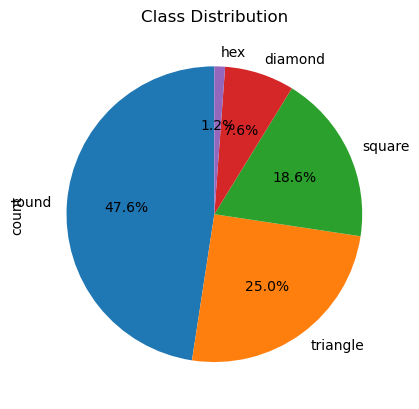

In [5]:
# A pie chart is used to visualize the class distribution
plot_pie_chart(data=shape_data, target='Shape', ax=None)
plt.title('Class Distribution')
plt.show()

Considerable class imbalance can be observed in the dataset. Hence we perform Stratified split to ensure that the distribution of classes is the same in both training and validation sets.

In [6]:
# split shape data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(shape_data, test_size=0.2, random_state=42, stratify=shape_data['Shape'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['Shape'])

In [7]:
train_data['Shape'].value_counts()

Shape
round       1056
triangle     556
square       412
diamond      169
hex           26
Name: count, dtype: int64

In [8]:
train_data.head()

,Path,Shape
3617,Dataset/trafficsigns_dataset/round/trafficdire...,round
592,Dataset/trafficsigns_dataset/square/parking/00...,square
32,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
380,Dataset/trafficsigns_dataset/square/laneend/00...,square
1846,Dataset/trafficsigns_dataset/triangle/warning/...,triangle


In [9]:
#copy train_data to new independent dataframe
train_data_new = train_data.copy()
train_data_new.head()

,Path,Shape
3617,Dataset/trafficsigns_dataset/round/trafficdire...,round
592,Dataset/trafficsigns_dataset/square/parking/00...,square
32,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
380,Dataset/trafficsigns_dataset/square/laneend/00...,square
1846,Dataset/trafficsigns_dataset/triangle/warning/...,triangle


In [10]:
import os
import shutil
def copy_images(df, path):
    """Copies the images from the original dataset to the new directory"""
    for index, row in train_data.iterrows():
        # Get the image path and shape
        image_path = row['Path']
        shape = row['Shape']

        # Create a new directory for the shape if it doesn't exist
        new_dir = os.path.join(path, shape)
        os.makedirs(new_dir, exist_ok=True)

        # Copy the image to the new directory
        shutil.copy2(image_path, new_dir)

In [11]:
path = 'Dataset/trafficsigns_dataset_train'
copy_images(train_data, path)

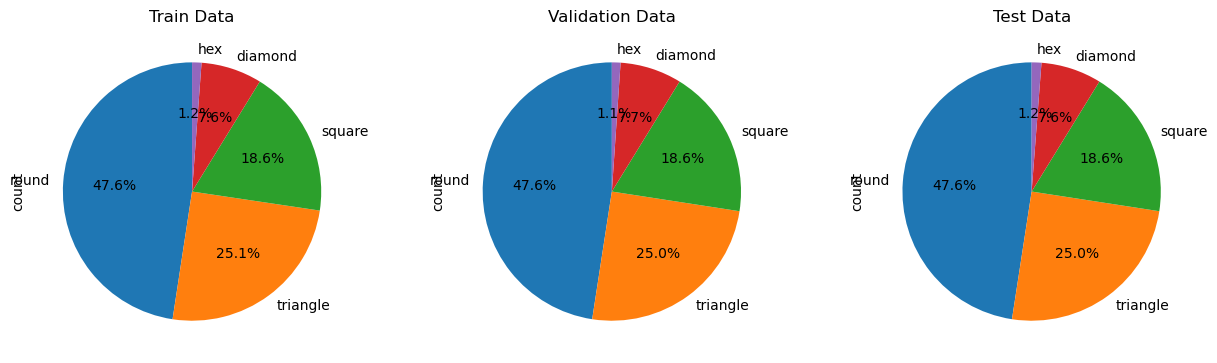

In [12]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 15))  # Adjust the figsize

# Plot the train pie chart in the first subplot
plot_pie_chart(data=train_data, target='Shape', ax=axs[0])
axs[0].set_title('Train Data')

# Plot the validation pie chart in the second subplot
plot_pie_chart(data=val_data, target='Shape', ax=axs[1])
axs[1].set_title('Validation Data')

# Plot the test pie chart in the third subplot
plot_pie_chart(data=test_data, target='Shape', ax=axs[2])
axs[2].set_title('Test Data')
plt.subplots_adjust(wspace=0.3)  

# Display the plot
plt.show()

From the above figure it is clear that we have preserved the class distribution in training, validation and test sets.

In [13]:
# print the shape of the train, validation, and test sets
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [14]:
# Convert the boolean encoding to integer
def bool_to_int(df_encoded) -> pd.DataFrame:
    """Convert boolean encoding to integer encoding"""
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded

In [15]:
# One-hot encode 'Shape' column in the train data
train_data = pd.get_dummies(train_data, columns=['Shape'])

# One-hot encode 'Shape' column in the validation data
val_data = pd.get_dummies(val_data, columns=['Shape'])

# One-hot encode 'Shape' column in the test data
test_data = pd.get_dummies(test_data, columns=['Shape'])

In [16]:
# Convert boolean encoding to integer encoding
train_data = bool_to_int(train_data)
val_data = bool_to_int(val_data)
test_data = bool_to_int(test_data)

train_data.head()

,Path,Shape_diamond,Shape_hex,Shape_round,Shape_square,Shape_triangle
3617,Dataset/trafficsigns_dataset/round/trafficdire...,0,0,1,0,0
592,Dataset/trafficsigns_dataset/square/parking/00...,0,0,0,1,0
32,Dataset/trafficsigns_dataset/diamond/rightofwa...,1,0,0,0,0
380,Dataset/trafficsigns_dataset/square/laneend/00...,0,0,0,1,0
1846,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1


In [17]:
# # convert the target column to string to work with keras ImageDataGenerator
# train_data['Shape'] = train_data['Shape'].astype('str')
# val_data['Shape'] = val_data['Shape'].astype('str')
# test_data['Shape'] = test_data['Shape'].astype('str')

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalize pixel values and build a data generator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# normalize pixel values and build a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# choose 32 as the batch size
batch_size = 32

# train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,  # make sure you have a dataframe for test data
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

Found 2219 validated image filenames.
Found 740 validated image filenames.
Found 740 validated image filenames.


### Metric Selection
Considering that this is a multi-class calssification problem and the existing class imbalance in the dataset, we choose, classwise Precision, Recall, F1 Score and Support as the evaluation metrics. We also plot a confusion matrix to understand the model performance better.

Setup Diagnostics

In [19]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Baseline CNN
We choose LeNet-5 as the baseline architecture for this task, as this architecture was originally developed for recognising handwritten digits of 28x28 size. As our data is also 28x28, we belive this architecture should be a good fit as a baseline.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=OUTPUT_CLASSES_SHAPE)
])

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-17 13:56:22.884264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 13:56:22.978648: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download an

We have decided to follow the common LeNet-5 architecture
* Convolutional Layer 1: 6 filters of size 5x5 - This configuration is good for small grayscale images
* Convolutional Layer 2: 16 filters of size 5x5 - This is a common configuration
* Max Pooling Layer 1: 2x2 - To reduce the spatial dimensions of the image by half
* Dense Layer 1: 120 - Learns higher-level representations from the flattened convolutional features
* Dense Layer 2: 84 - This is also a common configuration
Relu activation function is used for all layers except the output layer as it introduces non-linearity and helps to learn more complex representations. We use softmax activation function in the output layer as this is a multi-class classification problem(as it outputs class probabilities that sum to 1)


Epoch 1/75
 5/70 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.3062 - loss: 1.5451

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.3377 - loss: 1.2858 - val_AUC: 0.3436 - val_loss: 0.7193
Epoch 2/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 0.3904 - loss: 0.5958 - val_AUC: 0.4514 - val_loss: 0.4238
Epoch 3/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.4572 - loss: 0.3716 - val_AUC: 0.4397 - val_loss: 0.1948
Epoch 4/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.4406 - loss: 0.2207 - val_AUC: 0.4454 - val_loss: 0.1590
Epoch 5/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.4346 - loss: 0.1513 - val_AUC: 0.4598 - val_loss: 0.1015
Epoch 6/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - AUC: 0.4512 - loss: 0.1184 - val_AUC: 0.4573 - val_loss: 0.0784
Epoch 7/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.4490 - loss: 0.0675 - val_AUC: 0.4388 - val_loss: 0.0841
Epoch 8/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - AUC: 0.4471 - loss: 0.0544 - val_AUC: 0.4375 - val_loss: 0.1552
Epoch 9/75
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.4629 - loss: 0.

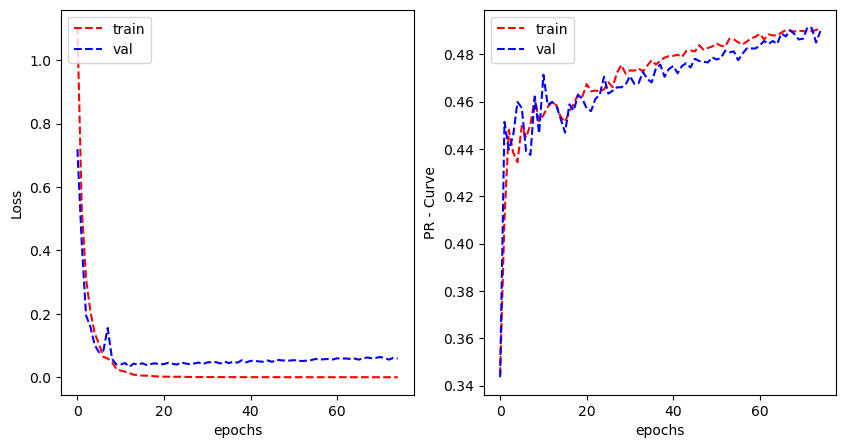

In [21]:
import tensorflow as tf


# Compile the model
model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(name="AUC", curve="PR")])

# Train the model
history_lenet_5 = model.fit(train_generator,
                                          validation_data=validation_generator,
                                          epochs=75,
                                          verbose=1)

# Plot the learning curves
plot_learning_curve(history_lenet_5.history['loss'], history_lenet_5.history['val_loss'],
                    history_lenet_5.history['AUC'], history_lenet_5.history['val_AUC'],
                    metric_name='PR - Curve')



In [22]:
from sklearn.metrics import classification_report
import numpy as np

def predict_labels(model, test_generator, test_data):
    # Get the class labels
    class_labels = list(test_data.columns[1:])
    # Predict on the test generator
    predictions = model.predict(test_generator)
    # Decode the predictions
    decoded_predictions = np.argmax(predictions, axis=1)
    # Map the decoded predictions to class labels
    predicted_labels = [class_labels[prediction] for prediction in decoded_predictions]
    # Assuming you have the true labels (y_true) and predicted labels (predicted_labels)
    y_true = test_data.iloc[:, 1:].idxmax(axis=1).values  # Get true labels from test_data
    # Calculate classification report
    report = classification_report(y_true, predicted_labels, target_names=class_labels)
    # Print the report
    print("\n################# Classification Report #################\n")
    print(report)

In [24]:
def calc_model_performance(model, train_generator, validation_generator):
    train_loss, train_auc = model.evaluate(train_generator, verbose=2)
    val_loss, val_auc = model.evaluate(validation_generator, verbose=2)
    test_loss, test_auc = model.evaluate(test_generator, verbose=2)
    print('\n################## Model Performance ######################\n')
    print(f'Train loss: {train_loss:.4f}, \nTrain AUC-PR: {train_auc:.4f}')
    print(f'Validation loss: {val_loss:.4f}, \nValidation AUC-PR: {val_auc:.4f}')
    print(f'Test loss: {test_loss:.4f}, \nTest AUC-PR: {test_auc:.4f}')

In [25]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 1s - 18ms/step - AUC: 0.4898 - loss: 2.5667e-05
24/24 - 1s - 22ms/step - AUC: 0.4897 - loss: 0.0589


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 - 1s - 22ms/step - AUC: 0.4790 - loss: 0.0546

################## Model Performance ######################

Train loss: 0.0000, 
Train AUC-PR: 0.4898
Validation loss: 0.0589, 
Validation AUC-PR: 0.4897
Test loss: 0.0546, 
Test AUC-PR: 0.4790


In [28]:
predict_labels(model, test_generator, test_data)

 7/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.07      0.07      0.07        56
     Shape_hex       0.00      0.00      0.00         9
   Shape_round       0.45      0.45      0.45       352
  Shape_square       0.18      0.18      0.18       138
Shape_triangle       0.24      0.24      0.24       185

      accuracy                           0.31       740
     macro avg       0.19      0.19      0.19       740
  weighted avg       0.32      0.31      0.31       740



In [182]:
import tensorflow as tf
reg_lambda = 0.001
model_lenet_5 = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dropout(.2),
    Dense(units=OUTPUT_CLASSES_SHAPE)
])



/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


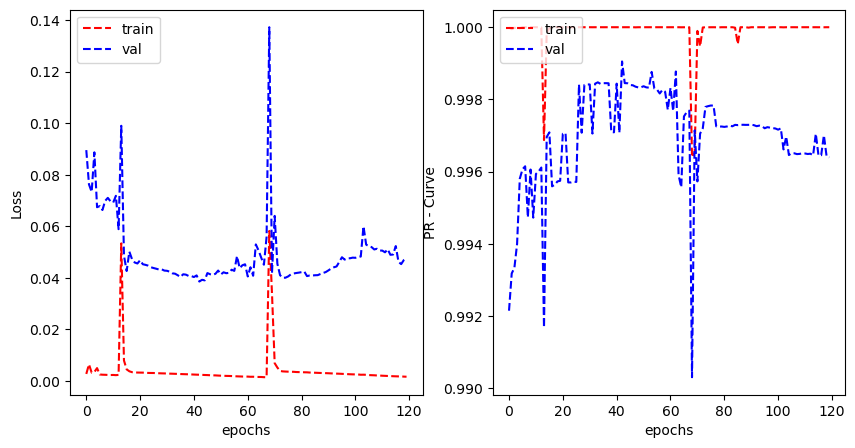

In [27]:
import tensorflow as tf


# Compile the model
model_lenet_5.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(name="AUC", curve="PR", from_logits=True)])

# Train the model
history_lenet_5 = model_lenet_5.fit(train_generator,
                                          validation_data=validation_generator,
                                          epochs=120,
                                          verbose=0)

# Plot the learning curves
plot_learning_curve(history_lenet_5.history['loss'], history_lenet_5.history['val_loss'],
                    history_lenet_5.history['AUC'], history_lenet_5.history['val_AUC'],
                    metric_name='PR - Curve')


In [52]:
####################FOLDER HAS TO EXIST BFRHAND####################
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Path to the dataset
data_dir = 'Dataset/trafficsigns_dataset_train'

# Path to save augmented images
augmented_dir = os.path.join('Dataset', 'trafficsigns_dataset_augmented')
os.makedirs(augmented_dir, exist_ok=True)


# List of minority classes and their sizes
minority_classes = {
    'triangle': 556,
    'square': 412,
    'diamond': 169,
    'hex': 26
}

# Size of the majority class
majority_class_size = 1056  # 'round'

# Create the data generator for the minority classes
minority_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented data for each minority class
for class_name, class_size in minority_classes.items():
    class_dir = os.path.join(data_dir, class_name)
    num_augmented_needed = majority_class_size - class_size

    # Generate augmented images for the minority class
    augmented_generator = minority_datagen.flow_from_directory(
        class_dir,
        target_size=(28, 28),
        batch_size=batch_size,
        save_to_dir=os.path.join(augmented_dir, class_name),
        save_prefix=f'{class_name}_aug',
        save_format='png',
        class_mode='binary'
    )

    # Generate the required number of augmented images
    for i in range(num_augmented_needed):
        next(augmented_generator)


Found 556 images belonging to 1 classes.


Found 412 images belonging to 1 classes.
Found 169 images belonging to 1 classes.
Found 26 images belonging to 1 classes.


In [53]:
# Traverse the folder tree and get the image paths, type and shape
path_to_dataset = 'Dataset/trafficsigns_dataset_augmented'
image_path = []
sign_shape = []
for shape_folder in os.listdir(path_to_dataset):
    shape_path = os.path.join(path_to_dataset, shape_folder)
    print(shape_path)
    if os.path.isdir(shape_path):
        # get the parent shape folders
        for image_file in os.listdir(shape_path):
            # save the image paths, type and shape
            image_path.append(os.path.join(shape_path, image_file))
            sign_shape.append(shape_folder)
                    

Dataset/trafficsigns_dataset_augmented/diamond
Dataset/trafficsigns_dataset_augmented/hex
Dataset/trafficsigns_dataset_augmented/triangle
Dataset/trafficsigns_dataset_augmented/square


In [54]:
# Create a DataFrame from the data
data = {'Path': image_path, 'Shape': sign_shape}
augmented_df = pd.DataFrame(data)
augmented_df.head(5)

,Path,Shape
0,Dataset/trafficsigns_dataset_augmented/diamond...,diamond
1,Dataset/trafficsigns_dataset_augmented/diamond...,diamond
2,Dataset/trafficsigns_dataset_augmented/diamond...,diamond
3,Dataset/trafficsigns_dataset_augmented/diamond...,diamond
4,Dataset/trafficsigns_dataset_augmented/diamond...,diamond


In [73]:
augmented_df.shape

(3061, 2)

In [74]:
# Count the number of each unique shape in the DataFrame
shape_counts = augmented_df['Shape'].value_counts()
print("Shape Counts:")
print(shape_counts)

Shape Counts:
Shape
hex         1030
diamond      887
square       644
triangle     500
Name: count, dtype: int64


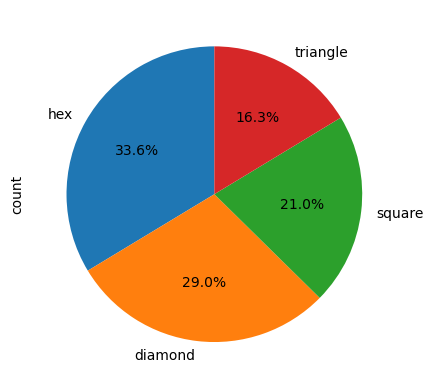

In [23]:
plot_pie_chart(data=augmented_df, target='Shape', ax=None)

In [75]:
# concatenate the augmented data to train_data
train_data_aug = pd.concat([train_data_new, augmented_df], ignore_index=True)

In [78]:
train_data_aug.shape

(5280, 2)

In [79]:
# concatenate train_data with df
# One-hot encode 'Shape' column in the train data
augmented_train_data = pd.get_dummies(train_data_aug, columns=['Shape'])

In [80]:
augmented_train_data = bool_to_int(augmented_train_data)

In [81]:
augmented_train_data.tail()

,Path,Shape_diamond,Shape_hex,Shape_round,Shape_square,Shape_triangle
5275,Dataset/trafficsigns_dataset_augmented/square/...,0,0,0,1,0
5276,Dataset/trafficsigns_dataset_augmented/square/...,0,0,0,1,0
5277,Dataset/trafficsigns_dataset_augmented/square/...,0,0,0,1,0
5278,Dataset/trafficsigns_dataset_augmented/square/...,0,0,0,1,0
5279,Dataset/trafficsigns_dataset_augmented/square/...,0,0,0,1,0


In [82]:
augmented_train_data.shape
# conver augmented_df_data to csv
augmented_train_data.to_csv('augmented_df_data.csv', index=False)

In [29]:
import matplotlib.pyplot as plt

def plot_class_distribution(classes, encoded=False):
    if encoded:
        class_labels = classes.columns[1:]
        class_counts = classes.iloc[:, 1:].sum().values
    else:
        class_labels = classes.unique()
        class_counts = classes.value_counts().values

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.show()


In [83]:
augmented_train_data.shape

(5280, 6)

In [84]:
# Count the number of each unique shape in the DataFrame which is onehot encoded
class_counts = augmented_train_data.sum()
class_counts

Path              Dataset/trafficsigns_dataset/round/trafficdire...
Shape_diamond                                                  1056
Shape_hex                                                      1056
Shape_round                                                    1056
Shape_square                                                   1056
Shape_triangle                                                 1056
dtype: object

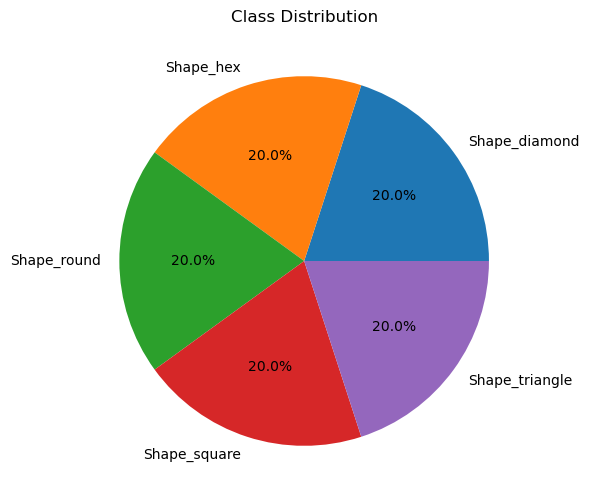

In [85]:
plot_class_distribution(augmented_train_data, encoded=True)